## Query and Generate response 
- at top-k = 10 model seems to generate the wrong query string and failed to retrieve

In [ ]:
import os
import pandas as pd
import re
import time
import csv
from io import StringIO

# Import the pipeline that calls the LLM
from utils.pipeline import run_pipeline

# Configurable parameter: top_k (must be less than 15)
TOP_K = 10  # Adjust as needed

# Paths
TESTSET_CSV_PATH = "../eval/evaluator_question.csv"  # Update if needed
BATTERY_FILES_DIR = "../resources/testset"
OUTPUT_DIR = "../eval"

def save_llm_responses():
    # Read the testset CSV
    df = pd.read_csv(TESTSET_CSV_PATH)
    
    # Identify and sort sample question columns (e.g., SAMPLE_QUESTION_1, SAMPLE_QUESTION_2, ...)
    sample_question_cols = sorted(
        [col for col in df.columns if col.startswith("SAMPLE_QUESTION")],
        key=lambda x: int(x.split('_')[-1])
    )
    
    output_rows = []
    total_cases = len(df)
    
    try:
        # Iterate over each test case
        for idx, row in df.iterrows():
            test_battery_id = row["TEST_BATTERY_ID"]
            test_battery_query_feature = row["TEST_BATTERY_QUERY_FEATURE"]
            print(f"\nProcessing test case {idx+1}/{total_cases}: Battery {test_battery_id} with feature '{test_battery_query_feature}'")
            battery_file_path = os.path.join(BATTERY_FILES_DIR, f"{test_battery_id}.txt")
            
            # Read the battery file content
            try:
                with open(battery_file_path, "r") as f:
                    file_content = f.read()
            except Exception as e:
                print(f"Error reading file for battery {test_battery_id}: {e}")
                continue
            
            # Prepare the row data dictionary with base columns
            row_data = {
                "TEST_BATTERY_ID": test_battery_id,
                "TEST_BATTERY_QUERY_FEATURE": test_battery_query_feature
            }
            
            # For each sample question, obtain the raw LLM response
            for i, question_col in enumerate(sample_question_cols, start=1):
                base_question = str(row[question_col]).strip()
                print(f"  Processing question {i}: {base_question}")
                
                # Improved instruction:
                # Ask the LLM to output exactly a comma-separated list of battery IDs, with no additional text.
                modified_question = (
                    f"{base_question} "
                    f"Return exactly a comma-separated list of the top-{TOP_K} battery IDs from the most similar batteries. "
                    "Do not include any explanation or extra text. Each battery ID must be in the format 'b<number>c<number>' "
                    "and the order should reflect ranking from most similar to least. For example, if the top-5 batteries are "
                    "b1c1, b1c2, b1c3, b1c4, and b1c5, then the response should be: b1c1, b1c2, b1c3, b1c4, b1c5. "
                    "Do not add any additional characters or text."
                )

                
                # Create a new file-like object for each call (to avoid pointer issues)
                uploaded_file = StringIO(file_content)
                
                try:
                    # Run the pipeline with the modified question and the file content
                    response = run_pipeline(modified_question, uploaded_file)
                    if isinstance(response, str):
                        raw_response = response
                    else:
                        raw_response = response.get("result", "")
                    print(f"    Received response: {raw_response[:100]}...")  # Print first 50 characters
                except Exception as e:
                    raw_response = f"API error: {str(e)}"
                    print(f"    Error processing battery {test_battery_id} question '{base_question}': {str(e)}")
                
                # Save the original question and its raw response in the row data
                row_data[f"q{i}"] = base_question
                row_data[f"q{i}_raw_response"] = raw_response
                
                # Optional delay between questions to avoid rate limiting
                time.sleep(1)
            
            output_rows.append(row_data)
    except Exception as global_error:
        print(f"\nA global error occurred: {str(global_error)}")
    finally:
        # Create a DataFrame from the collected rows even if an error occurred
        output_df = pd.DataFrame(output_rows)
        
        # Construct the output CSV path using the input CSV name
        input_csv_name = os.path.basename(TESTSET_CSV_PATH)
        output_csv_path = os.path.join(OUTPUT_DIR, f"llm_response_for_{input_csv_name}.csv")
        
        # Clean raw response columns to replace newlines with spaces and escape quotes
        for col in output_df.columns:
            if col.endswith("_raw_response"):
                output_df[col] = output_df[col].str.replace('\n', ' ', regex=False)
                output_df[col] = output_df[col].str.replace('"', '""', regex=False)
        
        # Write CSV with all fields quoted to protect against commas within fields
        output_df.to_csv(output_csv_path, index=False, quoting=csv.QUOTE_ALL)
        print(f"\nLLM responses saved to {output_csv_path}")

save_llm_responses()


ModuleNotFoundError: No module named 'utils'

## Evaluate

In [ ]:
import re
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configurable parameter
TOP_K = 3  # Change this to evaluate top-k

def extract_battery_ids(text):
    """
    Extract battery IDs matching the pattern: b{number}c{number}
    (returns a list in left-to-right order)
    """
    return re.findall(r'\bb\d+c\d+\b', text, flags=re.IGNORECASE)

def evaluate_query(ground_truth, pred_text, k):
    """
    For a single query, extract predicted battery IDs from the LLM response,
    ensure we have at least k predictions (pad with empty strings if needed),
    and then evaluate:
      - Binary outcome: 1 if the ground truth appears in the top-k, else 0.
      - Reciprocal Rank (RR): 1/(rank) if found; otherwise 0.
    """
    preds = extract_battery_ids(pred_text)
    # Pad with empty strings if fewer than k predictions
    if len(preds) < k:
        preds += [""] * (k - len(preds))
    found = 0
    rr = 0
    for i, p in enumerate(preds[:k]):
        if p.strip().lower() == ground_truth.strip().lower():
            found = 1
            rr = 1.0 / (i + 1)
            break
    return found, rr

# Load ground truth CSV and predicted responses CSV
gt_df = pd.read_csv("/home/jaf/battery-lifespan-kg/eval/evaluator_question.csv")
pred_df = pd.read_csv("/home/jaf/battery-lifespan-kg/eval/llm_response_for_evaluator_question.csv.csv")

# Merge the two dataframes based on test battery ID and query feature
merged_df = pd.merge(gt_df, pred_df, on=["TEST_BATTERY_ID", "TEST_BATTERY_QUERY_FEATURE"], how="inner")

# We assume there are three sample questions per row.
num_questions = 3
binary_labels = []  # 1 if correct (ground truth in top-k), else 0
rr_list = []       # Reciprocal Rank for each query

# Loop through each test case and each question
for idx, row in merged_df.iterrows():
    for i in range(1, num_questions + 1):
        gt_col = f"{i}_Most_Similar_Battery_ID"
        pred_col = f"q{i}_raw_response"
        if pd.isna(row.get(gt_col)):
            continue  # Skip if ground truth is not available
        ground_truth = str(row[gt_col])
        pred_text = str(row.get(pred_col, ""))
        label, rr = evaluate_query(ground_truth, pred_text, TOP_K)
        binary_labels.append(label)
        rr_list.append(rr)

# For our binary evaluation, ground truth labels for each query are all 1 (we expect it to be found)
y_true = [1] * len(binary_labels)
y_pred = binary_labels

# Use scikit-learn to compute metrics
topk_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
mrr = sum(rr_list) / len(rr_list) if rr_list else 0

print("Evaluation Metrics:")
print("Top-{} Accuracy: {:.2f}%".format(TOP_K, topk_accuracy * 100))
print("Mean Reciprocal Rank (MRR): {:.3f}".format(mrr))
print("Precision@{}: {:.3f}".format(TOP_K, precision))
print("Recall@{}: {:.3f}".format(TOP_K, recall))
print("F1 Score: {:.3f}".format(f1))


Evaluation Metrics:
Top-3 Accuracy: 56.00%
Mean Reciprocal Rank (MRR): 0.356
Precision@3: 1.000
Recall@3: 0.560
F1 Score: 0.718


In [ ]:
import re
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configurable parameter
TOP_K = 1 # Evaluate top-1; set to 3 if you want top-3, etc.

def extract_battery_ids(text):
    """
    Extract battery IDs matching the pattern b{number}c{number} in left-to-right order.
    For example, from "b1c1, b1c3" it returns ["b1c1", "b1c3"].
    """
    return re.findall(r'\bb\d+c\d+\b', text, flags=re.IGNORECASE)

def evaluate_query(ground_truth, pred_text, k):
    """
    For a single query:
      - Extract battery IDs from the predicted text.
      - If fewer than k predictions are returned, pad with empty strings.
      - Check if the ground truth is within the top k predictions.
      - Calculate the reciprocal rank (1/(rank position)) if found, or 0 if not.
      
    Returns:
      found (binary: 1 if correct answer is found in top-k, else 0),
      rr (reciprocal rank)
    """
    preds = extract_battery_ids(pred_text)
    if len(preds) < k:
        preds += [""] * (k - len(preds))
    found = 0
    rr = 0
    for idx, p in enumerate(preds[:k]):
        if p.strip().lower() == ground_truth.strip().lower():
            found = 1
            rr = 1.0 / (idx + 1)
            break
    return found, rr

# Load the ground truth and predicted responses CSV files.
gt_df = pd.read_csv("/home/jaf/battery-lifespan-kg/eval/evaluator_question.csv")
pred_df = pd.read_csv("/home/jaf/battery-lifespan-kg/eval/llm_response_for_evaluator_question.csv.csv")

# Merge dataframes on TEST_BATTERY_ID and TEST_BATTERY_QUERY_FEATURE.
merged_df = pd.merge(gt_df, pred_df, on=["TEST_BATTERY_ID", "TEST_BATTERY_QUERY_FEATURE"], how="inner")

# We'll assume there are three sample questions per row.
num_questions = 3

# Collect metrics for each query along with its feature.
records = []  # Each record: feature, binary label, and reciprocal rank (rr)

for idx, row in merged_df.iterrows():
    feature = row["TEST_BATTERY_QUERY_FEATURE"]
    for i in range(1, num_questions + 1):
        gt_col = f"{i}_Most_Similar_Battery_ID"  # Ground truth column for query i
        pred_col = f"q{i}_raw_response"            # LLM response column for query i
        if pd.isna(row.get(gt_col)):
            continue  # Skip if ground truth is missing
        ground_truth = str(row[gt_col])
        pred_text = str(row.get(pred_col, ""))
        label, rr = evaluate_query(ground_truth, pred_text, TOP_K)
        records.append({
            "feature": feature,
            "label": label,
            "rr": rr
        })

# Convert records to a DataFrame.
eval_df = pd.DataFrame(records)

# Now, compute and print metrics for each feature.
print("Per-feature evaluation metrics:\n")
for feature, group in eval_df.groupby("feature"):
    y_true = [1] * len(group)  # We expect the ground truth to be present in each query.
    y_pred = group["label"].tolist()
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    mrr = group["rr"].mean()
    
    print(f"Feature: {feature}")
    print(f"  Top-{TOP_K} Accuracy: {acc * 100:.2f}%")
    print(f"  Precision@{TOP_K}: {prec:.3f}")
    print(f"  Recall@{TOP_K}: {rec:.3f}")
    print(f"  F1 Score: {f1:.3f}")
    print(f"  Mean Reciprocal Rank (MRR): {mrr:.3f}\n")


Per-feature evaluation metrics:

Feature: cycle
  Top-1 Accuracy: 8.33%
  Precision@1: 1.000
  Recall@1: 0.083
  F1 Score: 0.154
  Mean Reciprocal Rank (MRR): 0.083

Feature: mean_grad_last_1000_cycles
  Top-1 Accuracy: 25.00%
  Precision@1: 1.000
  Recall@1: 0.250
  F1 Score: 0.400
  Mean Reciprocal Rank (MRR): 0.250

Feature: mean_grad_last_100_cycles
  Top-1 Accuracy: 33.33%
  Precision@1: 1.000
  Recall@1: 0.333
  F1 Score: 0.500
  Mean Reciprocal Rank (MRR): 0.333

Feature: mean_grad_last_10_cycles
  Top-1 Accuracy: 25.00%
  Precision@1: 1.000
  Recall@1: 0.250
  F1 Score: 0.400
  Mean Reciprocal Rank (MRR): 0.250

Feature: mean_grad_last_200_cycles
  Top-1 Accuracy: 33.33%
  Precision@1: 1.000
  Recall@1: 0.333
  F1 Score: 0.500
  Mean Reciprocal Rank (MRR): 0.333

Feature: mean_grad_last_300_cycles
  Top-1 Accuracy: 33.33%
  Precision@1: 1.000
  Recall@1: 0.333
  F1 Score: 0.500
  Mean Reciprocal Rank (MRR): 0.333

Feature: mean_grad_last_400_cycles
  Top-1 Accuracy: 25.00%
  Pr

# Visualize

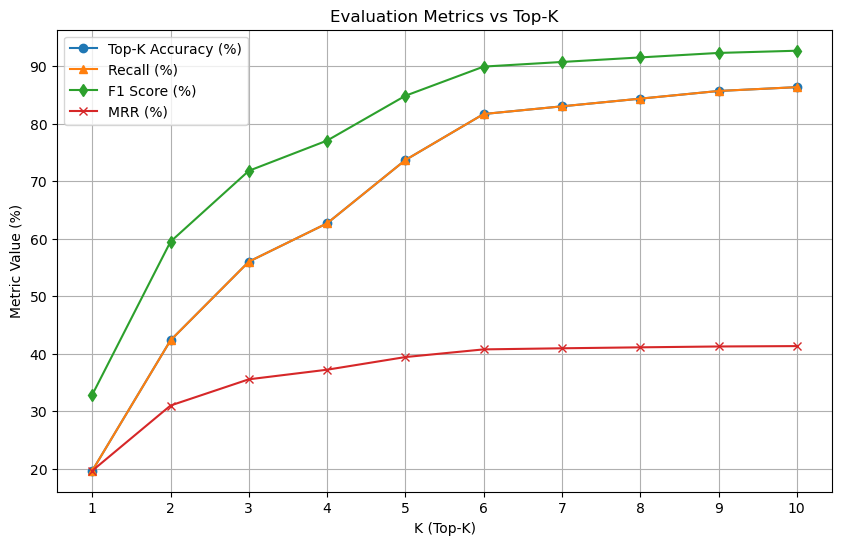

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configurable parameter: Evaluate for k=1,...,10
K_VALUES = range(1, 11)

def extract_battery_ids(text):
    """
    Extract battery IDs matching the pattern: b{number}c{number}
    (returns a list in left-to-right order)
    """
    return re.findall(r'\bb\d+c\d+\b', text, flags=re.IGNORECASE)

def evaluate_query(ground_truth, pred_text, k):
    """
    For a single query, extract predicted battery IDs from the LLM response,
    ensure we have at least k predictions (pad with empty strings if needed),
    and then evaluate:
      - Binary outcome: 1 if the ground truth appears in the top-k, else 0.
      - Reciprocal Rank (RR): 1/(rank) if found; otherwise 0.
    """
    preds = extract_battery_ids(pred_text)
    # Pad with empty strings if fewer than k predictions
    if len(preds) < k:
        preds += [""] * (k - len(preds))
    found = 0
    rr = 0
    for i, p in enumerate(preds[:k]):
        if p.strip().lower() == ground_truth.strip().lower():
            found = 1
            rr = 1.0 / (i + 1)
            break
    return found, rr

# Load ground truth CSV and predicted responses CSV
gt_df = pd.read_csv("/home/jaf/battery-lifespan-kg/eval/evaluator_question.csv")
pred_df = pd.read_csv("/home/jaf/battery-lifespan-kg/eval/llm_response_for_evaluator_question.csv.csv")

# Merge the two dataframes based on test battery ID and query feature
merged_df = pd.merge(gt_df, pred_df, on=["TEST_BATTERY_ID", "TEST_BATTERY_QUERY_FEATURE"], how="inner")

# We assume there are three sample questions per row.
num_questions = 3

# Prepare lists to store metrics for each k
accs = []
precisions = []
recalls = []
f1s = []
mrrs = []

# Evaluate over each k from 1 to 10
for k in K_VALUES:
    binary_labels = []  # Binary outcome for each query (1 if correct, else 0)
    rr_list = []       # Reciprocal Rank for each query
    # Loop through each test case and each sample question
    for idx, row in merged_df.iterrows():
        for i in range(1, num_questions + 1):
            gt_col = f"{i}_Most_Similar_Battery_ID"
            pred_col = f"q{i}_raw_response"
            if pd.isna(row.get(gt_col)):
                continue  # Skip if ground truth is not available
            ground_truth = str(row[gt_col])
            pred_text = str(row.get(pred_col, ""))
            label, rr = evaluate_query(ground_truth, pred_text, k)
            binary_labels.append(label)
            rr_list.append(rr)
    if len(binary_labels) == 0:
        # In case no queries were evaluated for this k, add zero values.
        accs.append(0)
        precisions.append(0)
        recalls.append(0)
        f1s.append(0)
        mrrs.append(0)
    else:
        # Our ground truth is that each query should return a correct answer (label=1)
        y_true = [1] * len(binary_labels)
        y_pred = binary_labels
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1_val = f1_score(y_true, y_pred, zero_division=0)
        mrr_val = sum(rr_list) / len(rr_list)
        accs.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1_val)
        mrrs.append(mrr_val)

# Plot metrics versus top-k
plt.figure(figsize=(10, 6))
plt.plot(K_VALUES, [a * 100 for a in accs], marker='o', label='Top-K Accuracy (%)')
plt.plot(K_VALUES, [r * 100 for r in recalls], marker='^', label='Recall (%)')
plt.plot(K_VALUES, [f * 100 for f in f1s], marker='d', label='F1 Score (%)')
plt.plot(K_VALUES, [m * 100 for m in mrrs], marker='x', label='MRR (%)')
plt.xlabel("K (Top-K)")
plt.ylabel("Metric Value (%)")
plt.title("Evaluation Metrics vs Top-K")
plt.xticks(list(K_VALUES))
plt.legend()
plt.grid(True)
plt.show()


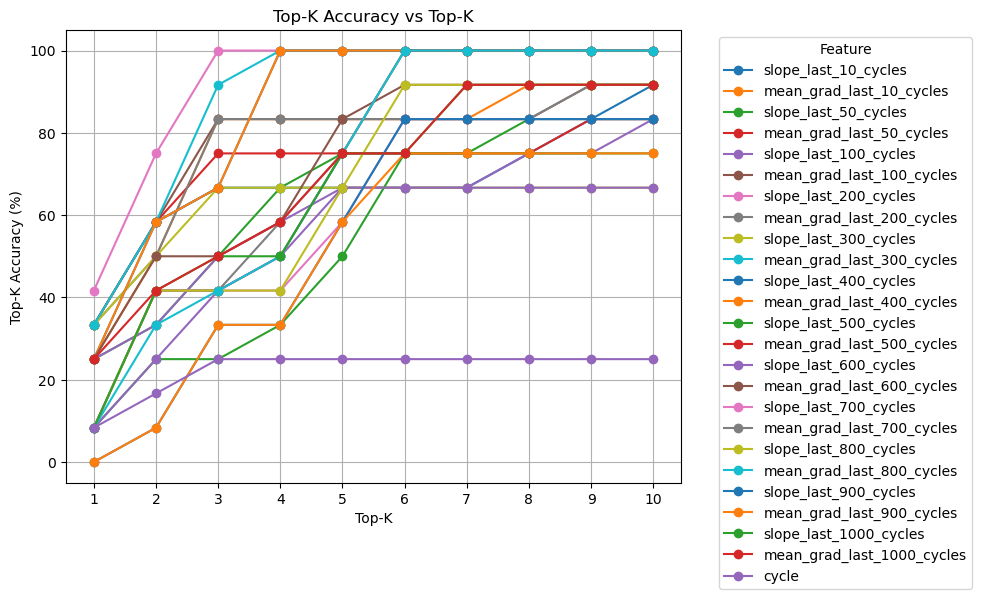

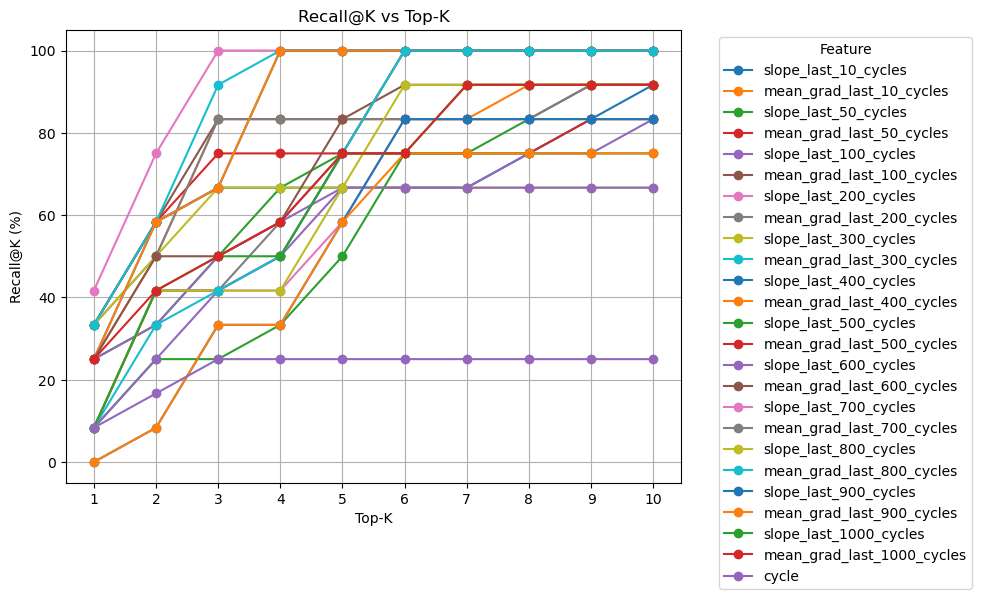

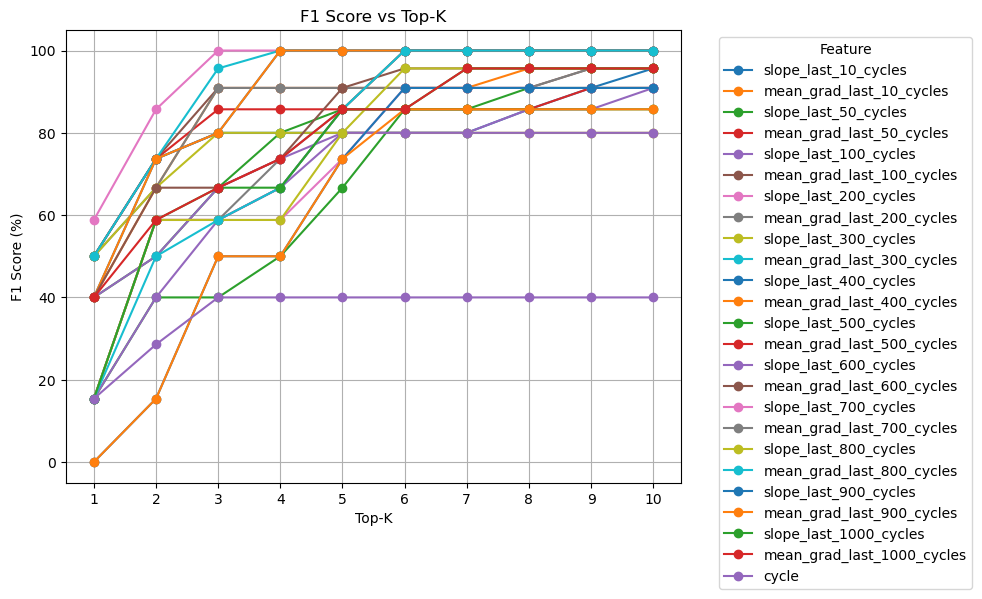

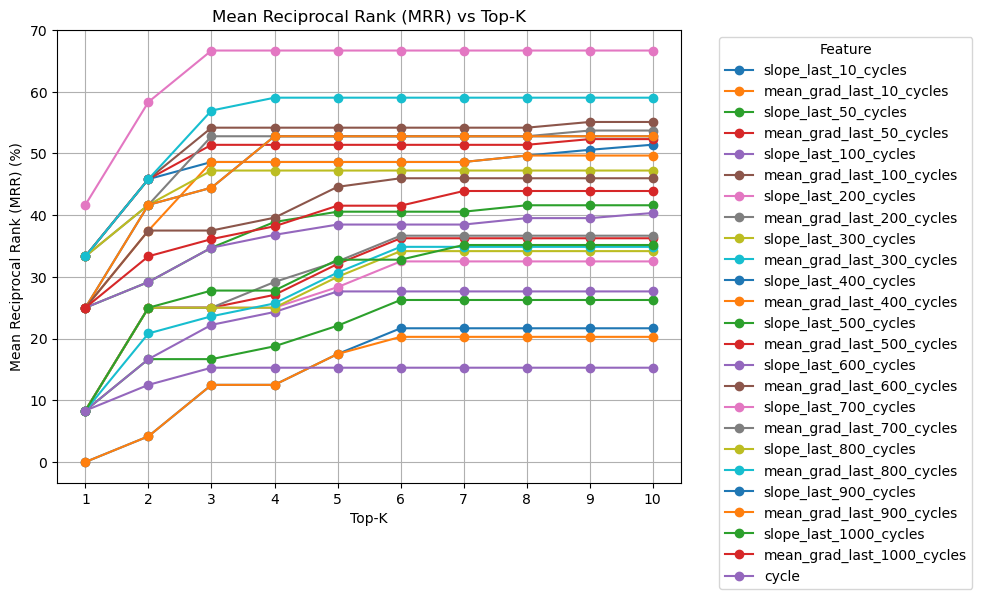

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# -------------------------------
# Helper functions
# -------------------------------

def extract_battery_ids(text):
    """
    Extract battery IDs matching the pattern b{number}c{number} in left-to-right order.
    For example, from "b1c1, b1c3" it returns ["b1c1", "b1c3"].
    """
    return re.findall(r'\bb\d+c\d+\b', text, flags=re.IGNORECASE)

def evaluate_query(ground_truth, pred_text, k):
    """
    For a single query:
      - Extract battery IDs from the predicted text.
      - If fewer than k predictions are returned, pad with empty strings.
      - Check if the ground truth is within the top k predictions.
      - Calculate the reciprocal rank (1/(rank position)) if found; otherwise 0.
      
    Returns:
      found (binary: 1 if correct answer is found in top-k, else 0),
      rr (reciprocal rank)
    """
    preds = extract_battery_ids(pred_text)
    if len(preds) < k:
        preds += [""] * (k - len(preds))
    found = 0
    rr = 0
    for idx, p in enumerate(preds[:k]):
        if p.strip().lower() == ground_truth.strip().lower():
            found = 1
            rr = 1.0 / (idx + 1)
            break
    return found, rr

# -------------------------------
# Load Data
# -------------------------------

# Ground truth CSV (evaluator_question.csv)
gt_df = pd.read_csv("/home/jaf/battery-lifespan-kg/eval/evaluator_question.csv")

# Predicted responses CSV (ensure the filename is correct)
pred_df = pd.read_csv("/home/jaf/battery-lifespan-kg/eval/llm_response_for_evaluator_question.csv.csv")

# Merge dataframes on TEST_BATTERY_ID and TEST_BATTERY_QUERY_FEATURE.
merged_df = pd.merge(gt_df, pred_df, on=["TEST_BATTERY_ID", "TEST_BATTERY_QUERY_FEATURE"], how="inner")

# -------------------------------
# Evaluation over multiple k values (from 1 to 10)
# -------------------------------

K_RANGE = range(1, 11)
num_questions = 3  # We assume there are three sample questions per row

# Get list of unique features
features = merged_df["TEST_BATTERY_QUERY_FEATURE"].unique()

# Create dictionaries to store metric values for each feature over k values
acc_dict = {feat: [] for feat in features}
prec_dict = {feat: [] for feat in features}
rec_dict = {feat: [] for feat in features}
f1_dict = {feat: [] for feat in features}
mrr_dict = {feat: [] for feat in features}

# For each feature and each top-k value, compute metrics.
for feat in features:
    feat_subset = merged_df[merged_df["TEST_BATTERY_QUERY_FEATURE"] == feat]
    for k in K_RANGE:
        binary_labels = []
        rr_list = []
        # Loop through each test case (each row) in this feature group
        for idx, row in feat_subset.iterrows():
            for i in range(1, num_questions + 1):
                gt_col = f"{i}_Most_Similar_Battery_ID"  # Ground truth column for question i
                pred_col = f"q{i}_raw_response"            # LLM response column for question i
                if pd.isna(row.get(gt_col)):
                    continue  # Skip if ground truth is missing
                ground_truth = str(row[gt_col])
                pred_text = str(row.get(pred_col, ""))
                label, rr = evaluate_query(ground_truth, pred_text, k)
                binary_labels.append(label)
                rr_list.append(rr)
        if len(binary_labels) == 0:
            # If no queries for this feature/k combination, set metrics to 0
            acc, prec, rec, f1, mrr = 0, 0, 0, 0, 0
        else:
            y_true = [1] * len(binary_labels)  # We expect ground truth to be present for each query.
            y_pred = binary_labels
            acc = accuracy_score(y_true, y_pred)
            prec = precision_score(y_true, y_pred, zero_division=0)
            rec = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            mrr = np.mean(rr_list)
        acc_dict[feat].append(acc)
        prec_dict[feat].append(prec)
        rec_dict[feat].append(rec)
        f1_dict[feat].append(f1)
        mrr_dict[feat].append(mrr)

# -------------------------------
# Plotting metrics vs top-k for each metric
# -------------------------------
import matplotlib.pyplot as plt

def plot_metric(metric_dict, metric_name):
    plt.figure(figsize=(10, 6))
    for feat, values in metric_dict.items():
        plt.plot(list(K_RANGE), [v * 100 for v in values], marker='o', label=feat)
    plt.xlabel("Top-K")
    plt.ylabel(f"{metric_name} (%)")
    plt.title(f"{metric_name} vs Top-K")
    plt.xticks(list(K_RANGE))
    plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric(acc_dict, "Top-K Accuracy")
# plot_metric(prec_dict, "Precision@K")
plot_metric(rec_dict, "Recall@K")
plot_metric(f1_dict, "F1 Score")
plot_metric(mrr_dict, "Mean Reciprocal Rank (MRR)")
